Checking: LJ021-0031.pt
Mel Shape: (80, 757) | Range: [-11.51, 1.82]
✅ Duration Sum (757) matches Mel Length (757)


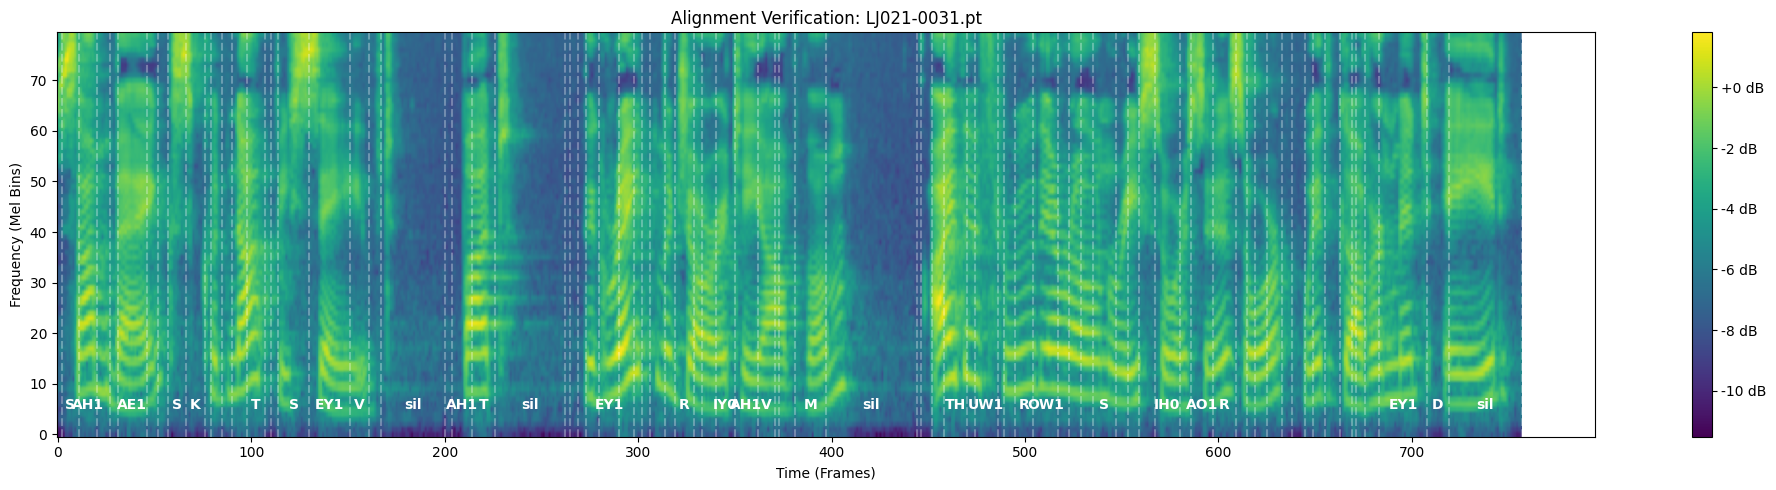

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path

import os
import sys

# Add src to path for imports
sys.path.append('../src')

# Try to import your symbols. If this fails, make sure you are in the project root.
try:
    from src.symbols_new import id_to_symbol
except ImportError:
    # Fallback if running directly inside a notebook without src path
    from src.symbols import id_to_symbol

def verify_dataset(num_samples=1):
    processed_dir = Path("../data/processed")
    files = list(processed_dir.glob("*.pt"))
    
    if not files:
        print("No .pt files found in data/processed!")
        return

    # Pick random files
    samples = random.sample(files, num_samples)

    for file_path in samples:
        data = torch.load(file_path)
        
        mel = data["mel_spectrogram"].numpy()
        durations = data["durations"].numpy()
        phonemes = data["phonemes"].numpy()

        # --- CHECK 1: MATH ---
        total_dur = np.sum(durations)
        mel_len = mel.shape[1]
        
        print(f"Checking: {file_path.name}")
        print(f"Mel Shape: {mel.shape} | Range: [{mel.min():.2f}, {mel.max():.2f}]")
        
        if total_dur == mel_len:
            print(f"✅ Duration Sum ({total_dur}) matches Mel Length ({mel_len})")
        else:
            print(f"❌ MISMATCH: Durations sum to {total_dur} but Mel is {mel_len}")

        # --- CHECK 2: VISUALIZATION ---
        plt.figure(figsize=(20, 5))
        
        # Plot Spectrogram (origin='lower' puts low freq at bottom)
        plt.imshow(mel, origin='lower', aspect='auto', cmap='viridis')
        
        # Overlay Phoneme Boundaries
        current_x = 0
        for i, (ph_id, dur) in enumerate(zip(phonemes, durations)):
            symbol = id_to_symbol[ph_id]
            
            # Draw boundary line
            plt.axvline(x=current_x + dur, color='white', alpha=0.3, linestyle='--')
            
            # Draw Label (only if duration is wide enough to read)
            if dur > 8: 
                plt.text(current_x + dur/2, 5, symbol, 
                         color='white', fontweight='bold', ha='center', fontsize=10, rotation=0)
            
            current_x += dur

        plt.title(f"Alignment Verification: {file_path.name}")
        plt.xlabel("Time (Frames)")
        plt.ylabel("Frequency (Mel Bins)")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

# Run the verification
verify_dataset(1)

In [4]:
print("Hello")

Hello


In [6]:
import torch
import torchaudio
import IPython.display as ipd
from pathlib import Path
from speechbrain.inference.vocoders import HIFIGAN

# --- CONFIGURATION ---
PROCESSED_DIR = "../data/processed"
OUTPUT_FILENAME = "verify_hifigan_test.wav"

# Standard LJSpeech parameters (22050Hz)
SAMPLE_RATE = 22050

def verify_hifigan():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # 1. Load HiFi-GAN (The Easy Way)
    # This automatically downloads the model to 'pretrained_models' if missing
    print("Loading SpeechBrain HiFi-GAN...")
    hifi_gan = HIFIGAN.from_hparams(
        source="speechbrain/tts-hifigan-ljspeech",
        savedir="../pretrained_models/tts-hifigan-ljspeech",
        run_opts={"device": device}
    )

    # 2. Pick a Random File
    p = Path(PROCESSED_DIR)
    files = list(p.glob("*.pt"))
    if not files:
        print(f"No .pt files found in {PROCESSED_DIR}")
        return

    import random
    target = random.choice(files)
    print(f"Processing file: {target.name}")

    # 3. Load Data
    data = torch.load(target)
    mel = data["mel_spectrogram"].to(device)

    # 4. Handle Dimensions
    # SpeechBrain HiFi-GAN expects [Batch, Mels, Time]
    # Our data is [Mels, Time], so we add a batch dimension
    if mel.dim() == 2:
        mel = mel.unsqueeze(0)  # -> [1, 80, Time]

    print(f"Mel Input Shape: {mel.shape}")
    print(f"Mel Stats: Mean={mel.mean():.4f}, Std={mel.std():.4f}, Min={mel.min():.4f}, Max={mel.max():.4f}")

    # 5. Generate Audio
    with torch.no_grad():
        # decode_batch takes [Batch, Mels, Time] and returns [Batch, Time]
        # (Note: Some versions might return [Batch, 1, Time], we handle both)
        waveform = hifi_gan.decode_batch(mel)

    # 6. Save & Display
    # Flatten to [1, Time] for torchaudio saving
    waveform = waveform.squeeze() # Remove all 1s
    waveform = waveform.unsqueeze(0) # Add channel dim back -> [1, Time]
    
    # Move to CPU for saving
    waveform = waveform.cpu()

    # Save
    torchaudio.save(OUTPUT_FILENAME, waveform, SAMPLE_RATE)
    print(f"✅ Audio saved to: {OUTPUT_FILENAME}")
    
    # (Optional) If running in Jupyter, this will play the audio
    try:
        ipd.display(ipd.Audio(waveform, rate=SAMPLE_RATE))
    except:
        pass

verify_hifigan()

Using device: cpu
Loading SpeechBrain HiFi-GAN...
Processing file: LJ008-0156.pt
Mel Input Shape: torch.Size([1, 80, 785])
Mel Stats: Mean=-5.6916, Std=2.0283, Min=-11.5129, Max=0.0849
✅ Audio saved to: verify_hifigan_test.wav
